In [1]:
import sys
import os
import importlib

# Ajout du chemin une fois
sys.path.append(os.path.abspath('../../python_files'))

# Liste des noms des modules à importer et recharger
module_names = [
    'preprocessing',
    'imports',
    'files',
    'clustering',
    'profile_prediction',
    'prediction_24h'
]

# Import et reload automatique
modules = {}
for name in module_names:
    modules[name] = importlib.import_module(name)
    importlib.reload(modules[name])

# Importer tout en global namespace (équivalent à from ... import *)
for name in module_names:
    exec(f'from {name} import *')


In [2]:
Simulation_Dataset = {
    "2018": "../../data/simulated_data_7years/Mal_isole/2018/Simulation_Outputs",
    "2019": "../../data/simulated_data_7years/Mal_isole/2019/Simulation_Outputs",
    "2020": "../../data/simulated_data_7years/Mal_isole/2020/Simulation_Outputs",
    "2021": "../../data/simulated_data_7years/Mal_isole/2021/Simulation_Outputs",
    "2022": "../../data/simulated_data_7years/Mal_isole/2022/Simulation_Outputs",
    "2023": "../../data/simulated_data_7years/Mal_isole/2023/Simulation_Outputs",
    "2024": "../../data/simulated_data_7years/Mal_isole/2024/Simulation_Outputs"   
}

Weather_Dataset = {
    "2018": "../../data/simulated_data_7years/Mal_isole/2018/Weather_Dataset.txt",
    "2019": "../../data/simulated_data_7years/Mal_isole/2019/Weather_Dataset.txt",
    "2020": "../../data/simulated_data_7years/Mal_isole/2020/Weather_Dataset.txt",
    "2021": "../../data/simulated_data_7years/Mal_isole/2021/Weather_Dataset.txt",
    "2022": "../../data/simulated_data_7years/Mal_isole/2022/Weather_Dataset.txt",
    "2023": "../../data/simulated_data_7years/Mal_isole/2023/Weather_Dataset.txt",
    "2024": "../../data/simulated_data_7years/Mal_isole/2024/Weather_Dataset.txt"   
}


In [8]:
consommation_chauffage = extract_and_concat_consommation(Simulation_Dataset, column_index=4, prefix="consommation_heat_")


### Clustering sur les trois premières années (2018, 2019, 2020) d'une période de 7 ans


In [9]:
start_date = "2018-01-01"
dates = pd.date_range(start=start_date, periods=len(consommation_chauffage), freq="D") 
consommation_chauffage.insert(0, "Date", dates)

consommation_chauffage = consommation_chauffage[consommation_chauffage['Date'].dt.year.isin([2018, 2019,2020])]



### Période sélectionnée : du 1er novembre au 31 avril


In [11]:
add_heating_season(consommation_chauffage)
df_conso = consommation_chauffage[consommation_chauffage["heat"] == 1].drop(columns=["heat"]).copy()

c:\Users\toubia\Desktop\pro\python_files\preprocessing.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['heat'] = ((month_day >= 1101) | (month_day <= 430)).astype(int)


In [12]:
clustering_heat_toulouse,centroids = clustering(
    df=df_conso.drop(columns=["Date"]),  
    n_parts=1,                          
    status_column="heat_on",           
    n_clusters_list=[3]                
)


In [13]:
centroids

{'clusters_1': array([[ 412.19799731,  490.13542337,  558.61308282,  628.44407447,
          705.0437902 ,  774.62148493,  843.91052763, 1501.7632674 ,
         1846.27294594, 1690.46024585, 1263.50426639,  519.29700336,
          252.06860776,  236.48571345,  224.28458692,  258.66641805,
          225.04053375,  185.87238525,  225.82635147,  265.67258163,
          318.05828459,  369.57446427,  423.6440982 ,  475.9965645 ],
        [ 738.52647009,  878.20849659, 1030.91438661, 1174.16006914,
         1311.76626906, 1413.6764747 , 1525.01997726, 3606.46612103,
         5209.71879665, 5745.21546641, 5635.22882384, 3249.1555892 ,
         1442.85540296, 1392.94001892, 1528.87140505, 1680.17330251,
         1233.45508839,   30.21888864,   93.06063396,   75.07310083,
          158.41474933,  183.29023454,  298.57161291,  382.65579246],
        [1678.97071882, 1821.35711281, 1960.23474833, 2093.7480967 ,
         2221.80670688, 2317.01861377, 2420.06786257, 4957.34379433,
         7078.4474

In [14]:
clustering_heat_toulouse['Date'] = df_conso['Date'].values


### Ajouter une colonne `cluster_reel` qui contient, pour chaque profil détecté, un vecteur de 24 valeurs représentant le centroïde exact correspondant.


In [18]:
centroids_array = centroids['clusters_1']

def get_centroid(cluster_label):
    idx = int(cluster_label)
    if idx == 3:
        return [0]*centroids_array.shape[1]  # vecteur nul de 24 valeurs
    return centroids_array[idx].tolist()

clustering_heat_toulouse['cluster_reel'] = clustering_heat_toulouse['clusters_1'].apply(get_centroid)

# Vérification
print(clustering_heat_toulouse[['clusters_1', 'cluster_reel']].head())

# Puis export si besoin
clustering_heat_toulouse.to_csv("../../data/simulated_data_7years/result_data/clustering_valeur exact_heat_3years_data_from_1_novembre_to_31_avril.csv", index=False)


   clusters_1                                       cluster_reel
0         0.0  [412.1979973065172, 490.1354233722732, 558.613...
1         1.0  [738.5264700869843, 878.2084965870066, 1030.91...
2         0.0  [412.1979973065172, 490.1354233722732, 558.613...
3         0.0  [412.1979973065172, 490.1354233722732, 558.613...
4         0.0  [412.1979973065172, 490.1354233722732, 558.613...


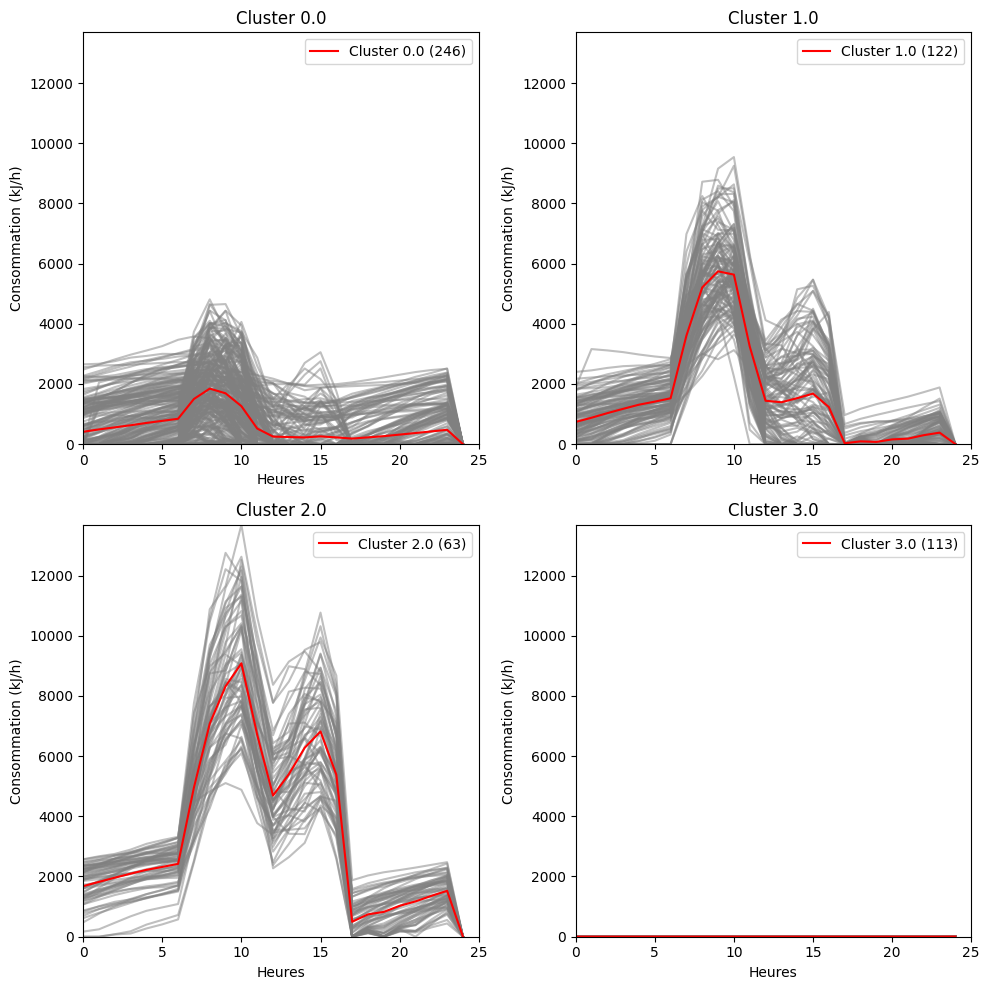

In [19]:
plot_clusters(clustering_heat_toulouse.drop(columns=["heat_on","Date"]))